TODO: Write project description and motivation

In [4]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

Cloning into 'HawkEye'...
remote: Enumerating objects: 11556, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 11556 (delta 6), reused 5 (delta 0), pack-reused 11537
Receiving objects: 100% (11556/11556), 1.12 GiB | 35.96 MiB/s, done.
Resolving deltas: 100% (7352/7352), done.
Updating files: 100% (11532/11532), done.


In [1]:
# Import necessary libraries
import os
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pandas as pd

data_dir = 'HawkEye/Data'

# Define function to read annotations
def read_annotations(xml_path):
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):

        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

# Define function to read images and annotations
def read_data(file_names, data_dir):
    # Initialize two empty lists
    data = []
    dims = []
    labels = []

    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:

        # Get the paths to the files
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Exclude 4-channel images
        if len(np.array(img).shape) != 3 or np.array(img).shape[2] != 3:
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img, annotations))

    return data, dims, labels

# Function to display image with annotations
def display_image_with_annotations(ax, image, annotations):
    # Create a copy of the image to draw on
    img_copy = image.copy()
    draw = ImageDraw.Draw(img_copy)

    # Draw annotations on the copy
    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        draw.text((xmin, ymin), label, fill='red')

    # Convert to numpy array for displaying with matplotlib
    img_array = np.array(img_copy)
    ax.imshow(img_array)
    ax.axis('off')


In [2]:
# Get the list of filenames (without extension)
file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]

# Read the data
train_data, train_obj_dims, labels = read_data(file_names, data_dir)

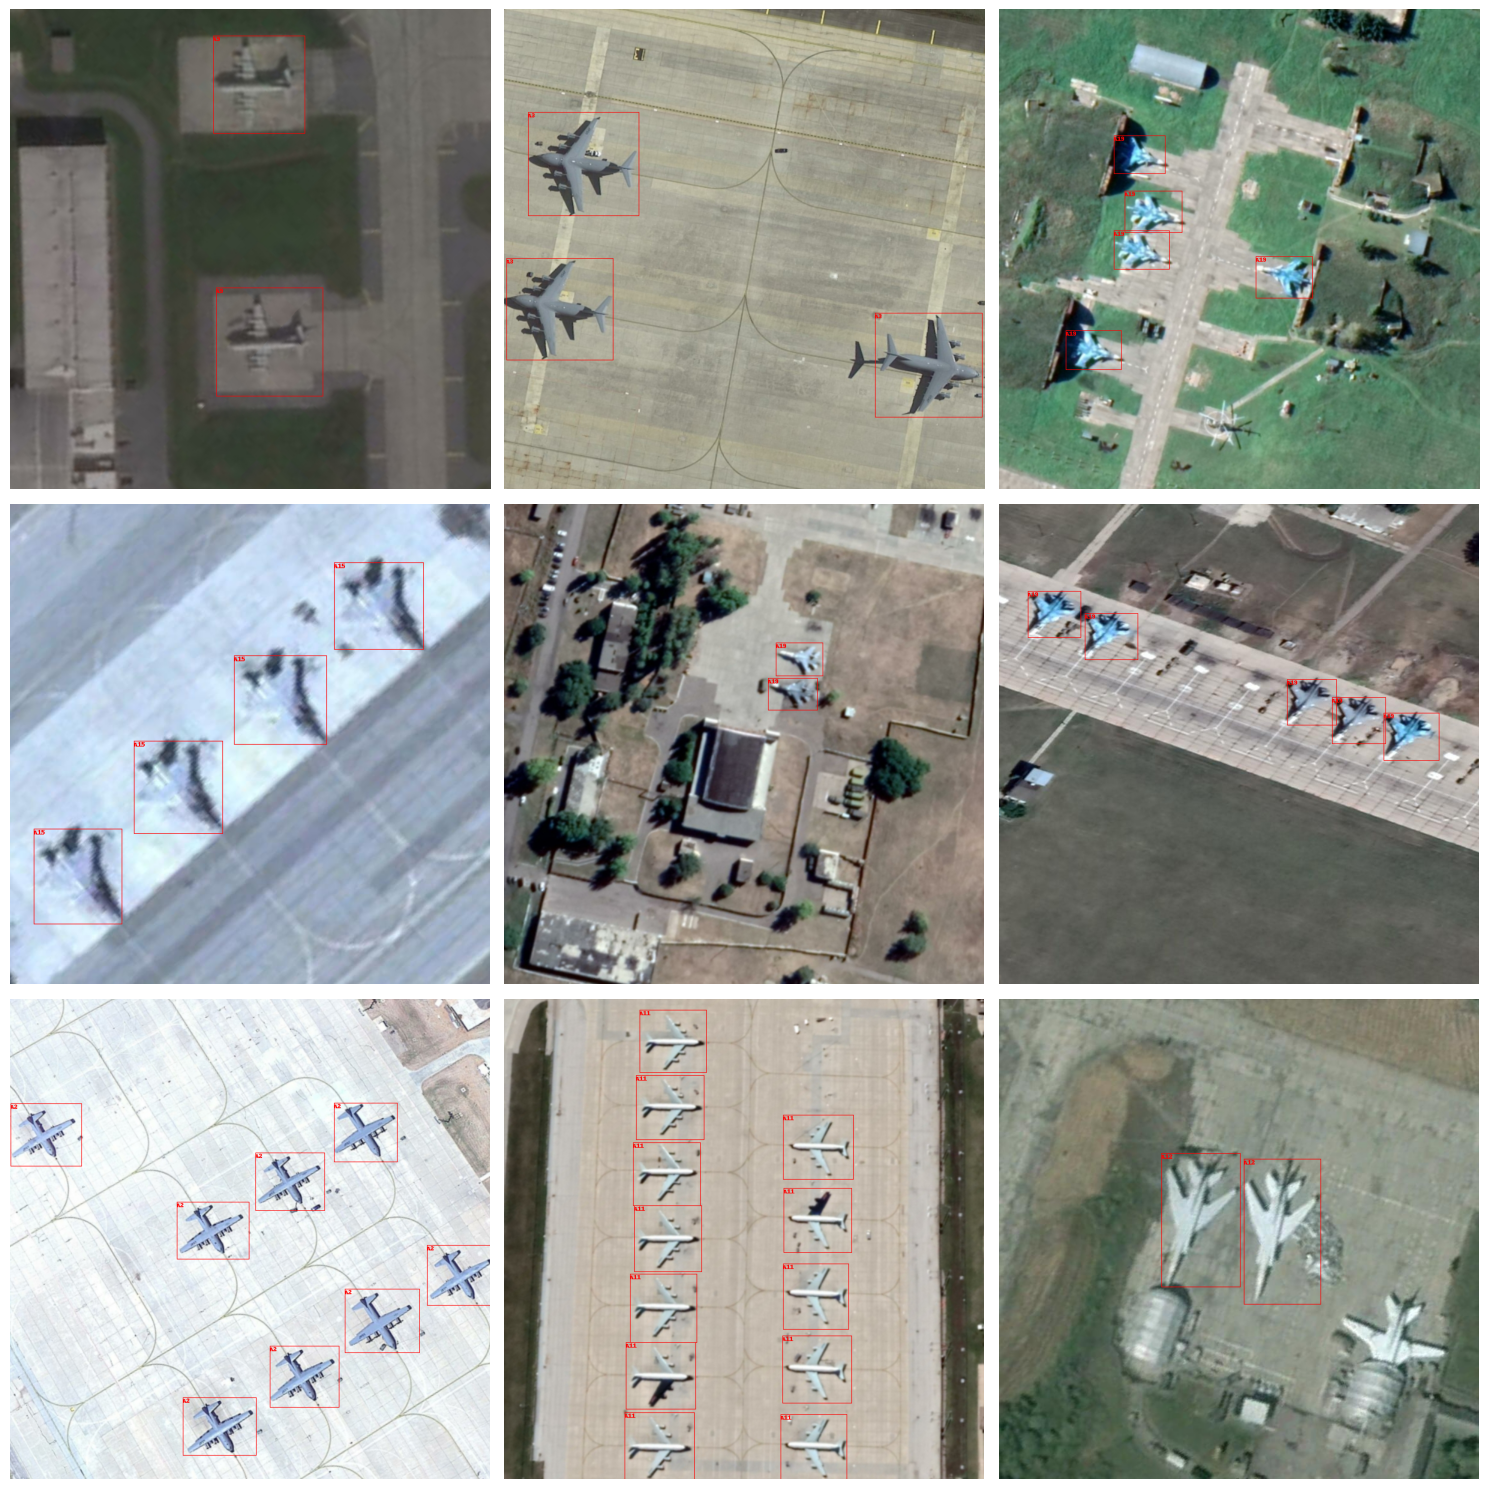

In [3]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for ax in axes:
    idx = np.random.randint(0, len(train_data) - 1)
    img = train_data[idx][0]
    annotations = train_data[idx][1]
    display_image_with_annotations(ax, img, annotations)
plt.tight_layout()
plt.show()

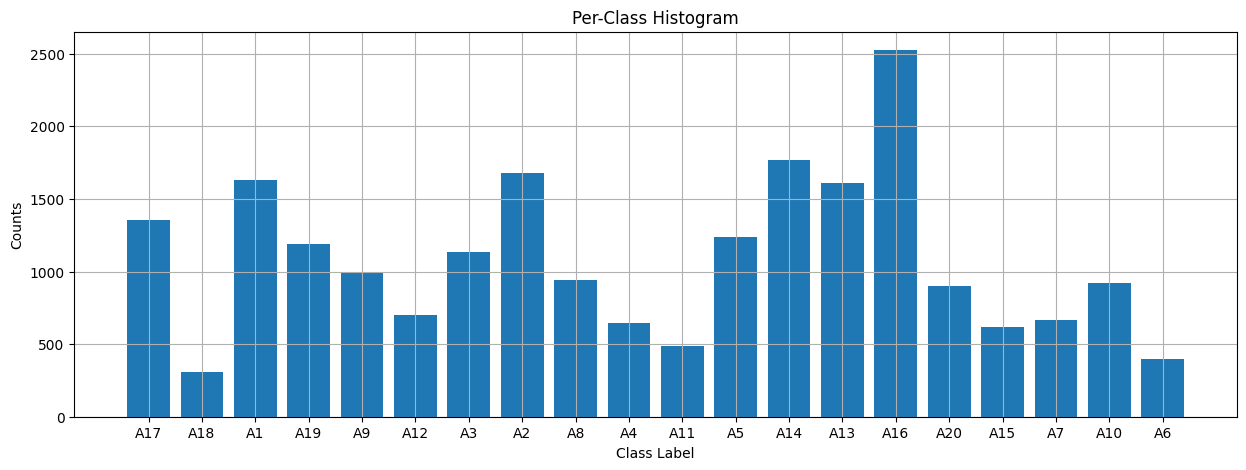

In [4]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()


In [8]:
# Print the per-class distribution
hist = Counter(labels)
sorted_hist = dict(sorted(hist.items()))

# Display the per-class distribution as text
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 1629 instances
Class A10: 924 instances
Class A11: 486 instances
Class A12: 699 instances
Class A13: 1611 instances
Class A14: 1768 instances
Class A15: 617 instances
Class A16: 2525 instances
Class A17: 1352 instances
Class A18: 308 instances
Class A19: 1192 instances
Class A2: 1678 instances
Class A20: 900 instances
Class A3: 1132 instances
Class A4: 642 instances
Class A5: 1236 instances
Class A6: 396 instances
Class A7: 667 instances
Class A8: 944 instances
Class A9: 996 instances


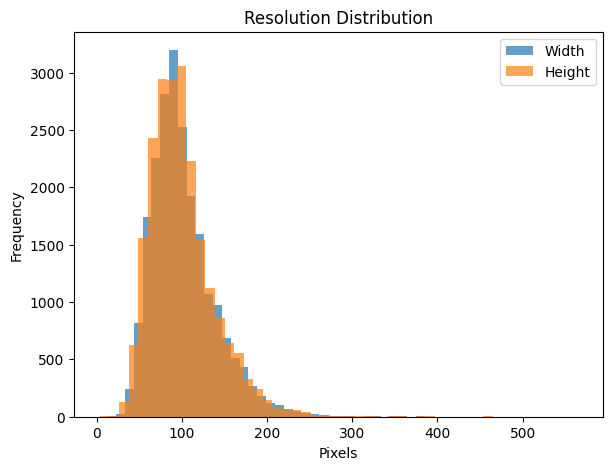

In [5]:
# Analyze resolution distribution
resolutions = pd.DataFrame(train_obj_dims, columns=['Width', 'Height'])

# Plot resolution distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(resolutions['Width'], bins=50, alpha=0.7, label='Width')
plt.hist(resolutions['Height'], bins=50, alpha=0.7, label='Height')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Resolution Distribution')
plt.legend()
plt.show()

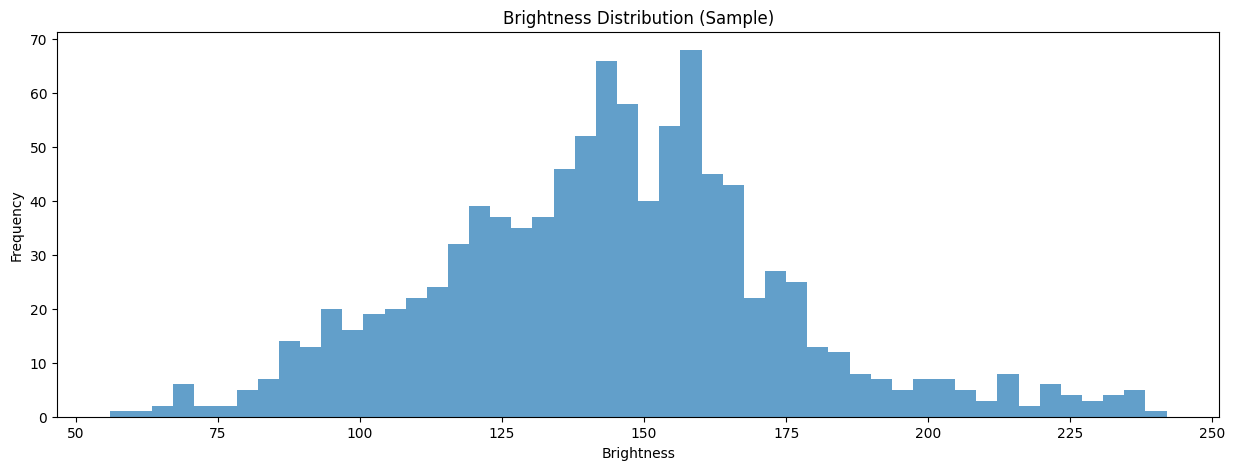

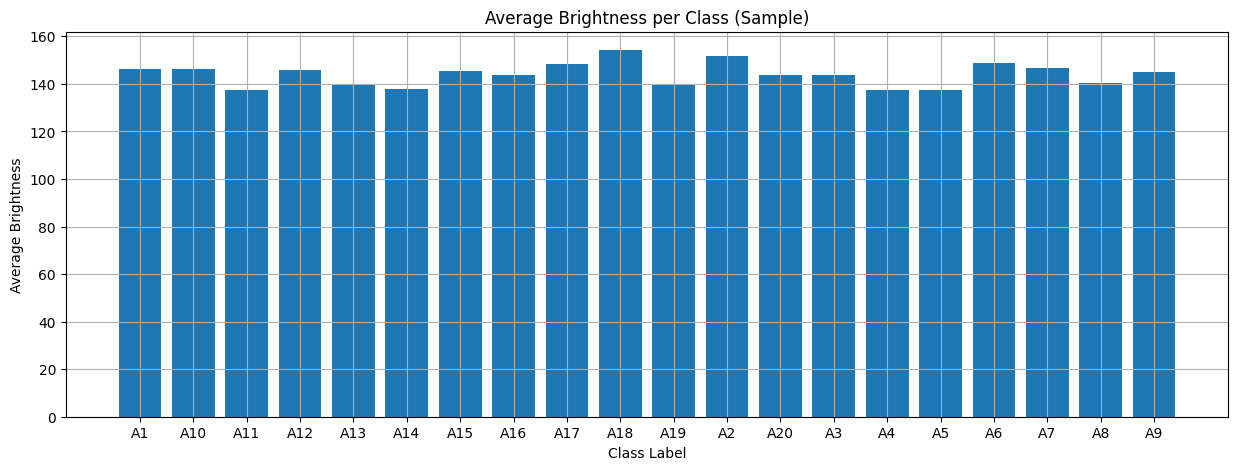

In [6]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(train_data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img = train_data[idx][0].convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

# Brightness distribution per class for the sample
sample_labels = [labels[idx] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()
